In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN  # Changed for SMOTEENN
from imblearn.over_sampling import ADASYN  # Alternative option
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_curve, average_precision_score,
                             classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [10]:
# %% [code] - Data Preprocessing
# Load original data
original_df = pd.read_excel(r'C:\Project\livertransplant\datasets\GRWR _0.8.xlsx', sheet_name='Sheet1')

# Print EXACT column names with hidden characters
print("Original Columns (Exact Names):")
print([repr(col) for col in original_df.columns])

# Create working copy with renamed column
working_df = original_df.copy(deep=True)

# Define column names
exact_long_col = 'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'


# Create working copy with guaranteed rename
working_df = original_df.copy()
working_df.rename(columns={exact_long_col: 'Diagnosis_Code'}, inplace=True)

# Validate rename
assert 'Diagnosis_Code' in working_df.columns, "Rename failed! Check exact_long_col"
print("\nWorking Copy Columns:", working_df.columns.tolist())

# Clean columns in working copy
columns_to_drop = [
    'Tx No', 'Name', 'UHID', 'Adult  = 0; ped = 1 ',
    'Portal vein thrombosis', 'Preoperative HCC',
    'date of surgery', 'additional procedures',
    'Post op Ascites N=0; Y = 1', 'Post op Day 1 bili',
    'post op Day 7 bili', 'INR on day 7', 'Grade3/4 encephalopathy N=0/Y=1',
    'Early graft dysfunction N =0/Y=1', 'HAT', 'PVT',
    'Biliary complications', 'Post op AKI N= 0; Y = 1',
    'Post op sepsis N=0; Y = 1', 'Rexploration N= 0 ; Y = 1',
    'Length of hospital stay', 'Alive/Dead 0 = 0; D=1',
    'in-hospital mortality Y=1, N=0', 'Date of death',
    'Highest clavein dindo score', 'Length of Followup',
    'Other postop complication', 'Cause of death',
    'Additional comments'
 
]
# Ensure no hidden spaces in column names
working_df.columns = working_df.columns.str.strip()

# Drop unwanted columns
working_df = working_df.drop(columns_to_drop, axis=1, errors='ignore')

# Validate if drop worked
print("Remaining Columns after dropping unwanted ones:", working_df.columns.tolist())

# Handle missing values
categorical_cols = working_df.select_dtypes(include=['object']).columns
numerical_cols = working_df.select_dtypes(include=['number']).columns

# Fill categorical columns with mode
for col in categorical_cols:
    working_df[col] = working_df[col].fillna(working_df[col].mode()[0])

# Fill numerical columns with median
for col in numerical_cols:
    working_df[col] = working_df[col].fillna(working_df[col].median())

# Handle missing values
working_df['SFSS Y=1/N=0'] = working_df['SFSS Y=1/N=0'].fillna(0).astype(int)
working_df = working_df.apply(pd.to_numeric, errors='coerce')
working_df = working_df.dropna(axis=1, how='all')
working_df = working_df.fillna(working_df.median())


Original Columns (Exact Names):
["'Tx No'", "'Name'", "'UHID'", "'Age'", "'Gender M = 0; F = 1'", "'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'", "'BMI '", "'MELD/PELD'", "'Adult  = 0; ped = 1 '", "'Portal vein thrombosis'", "'Preoperative HCC'", "'date of surgery'", "'Donor Age'", "'Donor Gender M = 0; F=1'", "'Lobe - RL=0, RPS = 1, LL = 2'", "'additional procedures'", "'Graft wt '", "'GRWR'", "'Blood loss'", "'CIT'", "'WIT'", "'Portal velocity'", "'Pre-reperfusion portal pressure'", "'Post- reperfusion portal pressure'",

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [11]:
# Define target and features
target_column = 'SFSS Y=1/N=0'  # Verify exact target column name
X = working_df.drop(columns=[target_column])
y = working_df[target_column]

In [12]:
# Split into train/test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True
)

# Feature scaling (critical for SMOTEENN/ADASYN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTEENN (recommended first) only on training data
resampler = SMOTEENN(random_state=42)
X_res, y_res = resampler.fit_resample(X_train_scaled, y_train)

print(f"\nClass distribution after SMOTEENN:")
print(pd.Series(y_res).value_counts())


Class distribution after SMOTEENN:
SFSS Y=1/N=0
1    136
0     75
Name: count, dtype: int64


In [13]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

results = []
feature_importances = []

for name, model in models:
    # Training
    model.fit(X_res, y_res)
    
    # Evaluation
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    metrics = {
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 3),
        'Precision': round(precision_score(y_test, y_pred), 3),
        'Recall': round(recall_score(y_test, y_pred), 3),
        'F1': round(f1_score(y_test, y_pred), 3),
        'AUC': round(roc_auc_score(y_test, y_proba), 3)
    }
    results.append(metrics)
    
    # Feature importance collection
    if hasattr(model, 'feature_importances_'):
        feature_importances.append({
            'model': name,
            'importances': model.feature_importances_
        })
    
    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame(results)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.47      0.62        36
           1       0.05      0.33      0.09         3

    accuracy                           0.46        39
   macro avg       0.47      0.40      0.35        39
weighted avg       0.83      0.46      0.58        39


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.20      0.33      0.25         3

    accuracy                           0.85        39
   macro avg       0.57      0.61      0.58        39
weighted avg       0.88      0.85      0.86        39


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86        36
           1       0.20      0.67      0.31         3

    accuracy                           0.77        39
   macro avg  


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.462,0.050,0.333,0.087,0.352
1,Random Forest,0.846,0.200,0.333,0.250,0.634
2,XGBoost,0.769,0.200,0.667,0.308,0.704


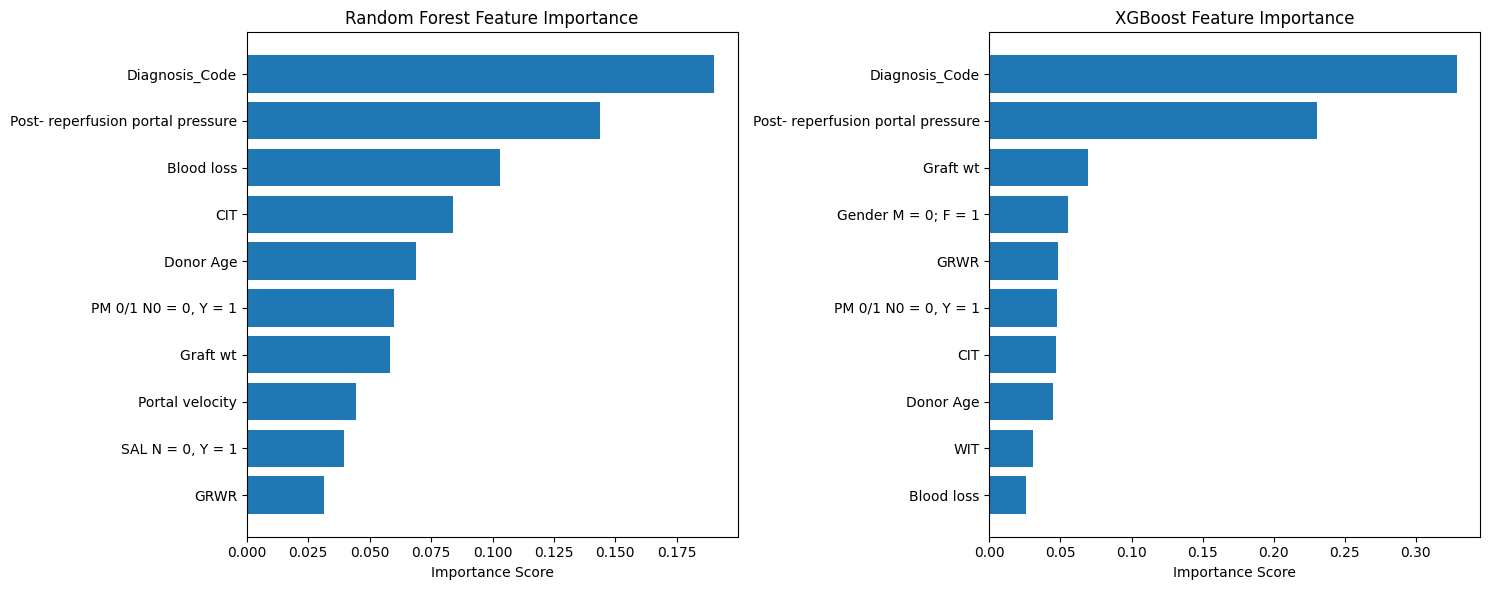


Data types in results:
Model         object
Accuracy     float64
Precision    float64
Recall       float64
F1           float64
AUC          float64
dtype: object

Non-numeric values check:
Column 'Model' contains non-numeric values:
0    Logistic Regression
1          Random Forest
2                XGBoost
Name: Model, dtype: object


In [14]:
# %% [code] - Fixed Results Visualization
import matplotlib.pyplot as plt

# Performance comparison - fixed formatting
print("\nModel Performance Comparison:")
def safe_format(x):
    """Handle both numeric and string formatting"""
    try:
        return f"{float(x):.3f}" if str(x).replace('.','',1).isdigit() else str(x)
    except:
        return str(x)

display(results_df.style.format(safe_format))

# Feature importance plot - more robust version
if feature_importances:
    plt.figure(figsize=(15, 6))
    for idx, fi in enumerate(feature_importances, 1):
        plt.subplot(1, len(feature_importances), idx)
        
        # Ensure we have valid feature names and importances
        valid_mask = ~np.isnan(fi['importances'])
        valid_importances = fi['importances'][valid_mask]
        valid_features = X.columns[valid_mask]
        
        # Get top 10 features
        if len(valid_importances) > 0:
            top_n = min(10, len(valid_importances))
            indices = np.argsort(valid_importances)[-top_n:]
            
            plt.title(f"{fi['model']} Feature Importance")
            plt.barh(range(len(indices)), valid_importances[indices], align='center')
            plt.yticks(range(len(indices)), valid_features[indices])
            plt.xlabel('Importance Score')
        else:
            plt.title(f"{fi['model']} - No Valid Features")
    
    plt.tight_layout()
    plt.show()

# %% [code] - Additional Data Checks
# Verify data types in results_df
print("\nData types in results:")
print(results_df.dtypes)

# Check for non-numeric values in metrics
print("\nNon-numeric values check:")
for col in results_df.columns:
    non_numeric = results_df[col].apply(lambda x: not str(x).replace('.','',1).isdigit())
    if non_numeric.any():
        print(f"Column '{col}' contains non-numeric values:")
        print(results_df[col][non_numeric])

In [19]:
# %% [code] - Correct Visualization Setup
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Modern style configuration
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name
sns.set_theme(style="whitegrid", palette="husl")  # Proper seaborn initialization
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (10, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})
%matplotlib inline

In [ ]:
# %% [code] - Clinical Performance Metrics Table
def generate_metrics_table(models, X_test, y_test):
    """Generate styled metrics table with clinical emphasis"""
    metrics = []
    for name, model in models:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        metrics.append({
            'Model': name,
            'Accuracy': f"{accuracy_score(y_test, y_pred):.2f}",
            'Precision': f"{precision_score(y_test, y_pred):.2f}",
            'Recall (Sensitivity)': f"{recall_score(y_test, y_pred):.2f}",
            'Specificity': f"{recall_score(y_test, y_pred, pos_label=0):.2f}",
            'F1 Score': f"{f1_score(y_test, y_pred):.2f}",
            'AUC-ROC': f"{roc_auc_score(y_test, y_proba):.2f}",
            'AUPRC': f"{average_precision_score(y_test, y_proba):.2f}"
        })
    
    df = pd.DataFrame(metrics)
    styled_df = df.style \
        .highlight_max(props='color:white; background-color:#2ecc71', subset=['AUC-ROC', 'Recall (Sensitivity)']) \
        .set_caption("Clinical Performance Metrics (SFSS = Positive Class)")
    
    return styled_df

# Generate and display metrics table
print("\n" + "="*80)
print("CLINICAL PERFORMANCE METRICS")
print("="*80)
display(generate_metrics_table(models, X_test_scaled, y_test))


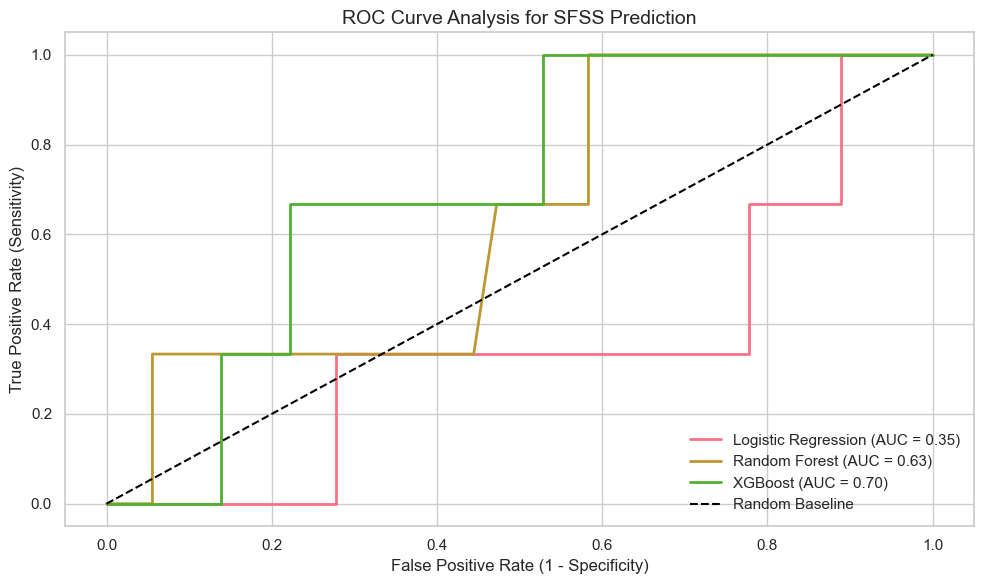

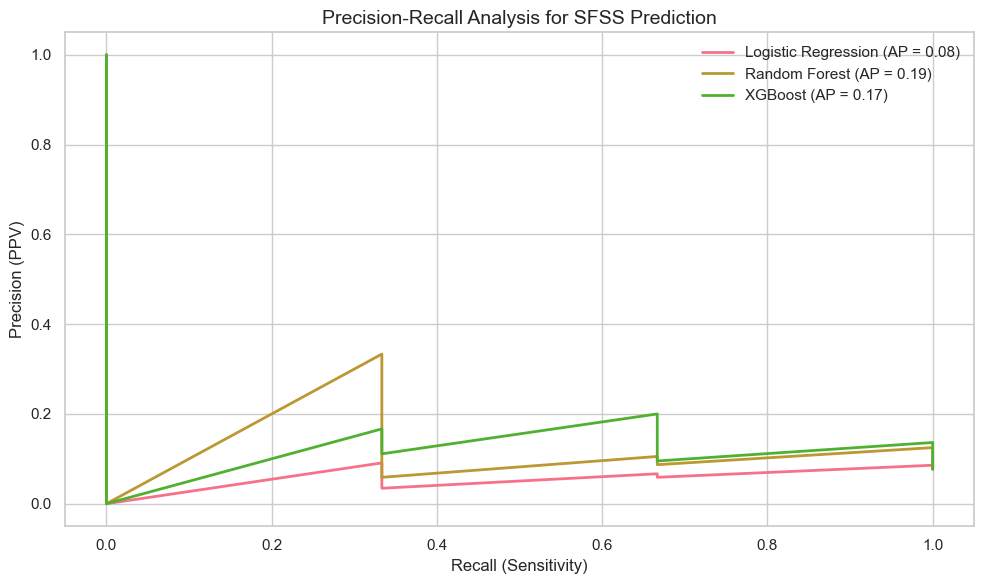


CONFUSION MATRIX ANALYSIS


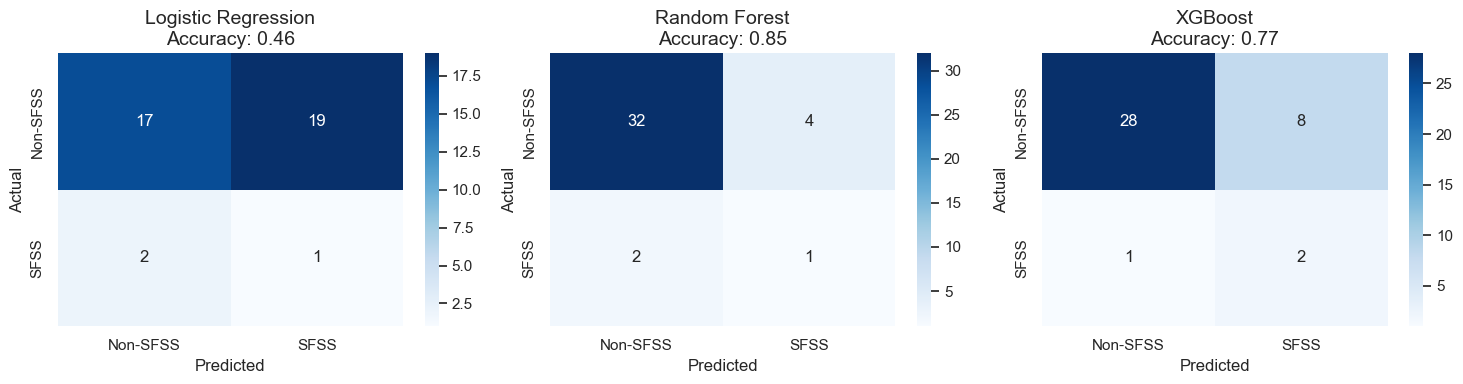


CLINICAL FEATURE IMPORTANCE


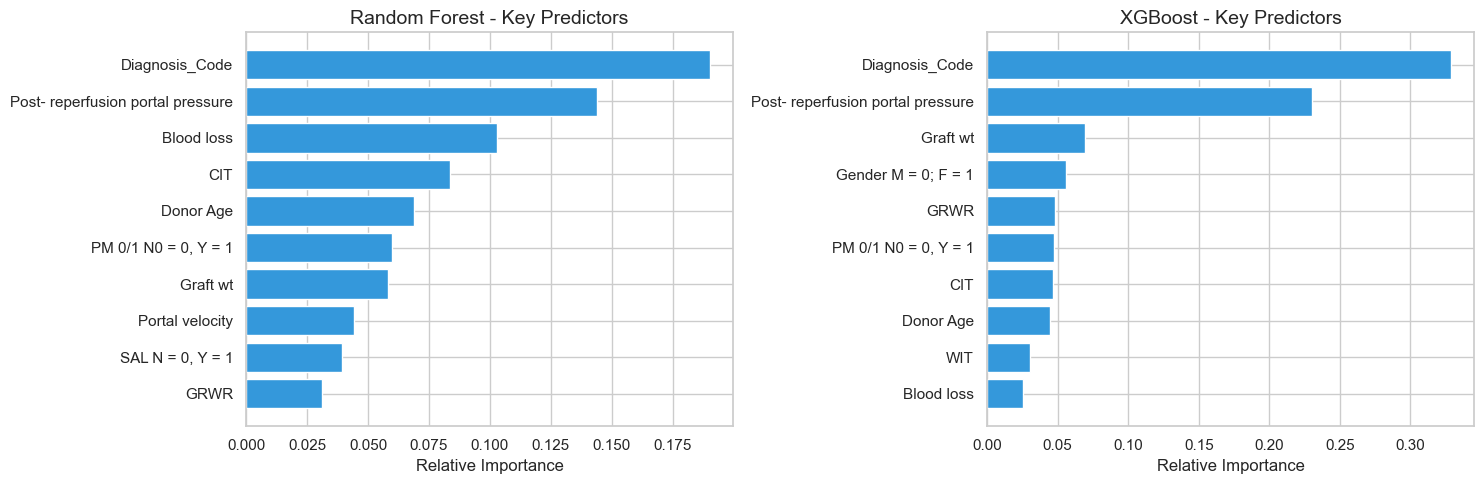


CLINICAL IMPLEMENTATION SUMMARY
Total Patients in Test Set: 39
SFSS Cases in Test Set: 3 (7.7%)

Recommended Model: XGBoost (AUC = 0.70)
❌ Below Required AUC Threshold - Consider:
   - Additional feature engineering
   - Hyperparameter optimization
   - Alternative augmentation strategies


In [22]:
# %% [code] - ROC Curve Visualization
plt.figure(figsize=(10, 6))
for name, model in models:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, 
             label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve Analysis for SFSS Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [code] - Precision-Recall Visualization
plt.figure(figsize=(10, 6))
for name, model in models:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, lw=2,
             label=f'{name} (AP = {average_precision_score(y_test, y_proba):.2f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Analysis for SFSS Prediction')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [code] - Confusion Matrix Visualization
print("\n" + "="*80)
print("CONFUSION MATRIX ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
if len(models) == 1:
    axes = [axes]

for idx, (name, model) in enumerate(models):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-SFSS', 'SFSS'],
                yticklabels=['Non-SFSS', 'SFSS'],
                ax=axes[idx])
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.2f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# %% [code] - Feature Importance Visualization
print("\n" + "="*80)
print("CLINICAL FEATURE IMPORTANCE")
print("="*80)

if feature_importances:
    fig, axes = plt.subplots(1, len(feature_importances), figsize=(15, 5))
    for idx, fi in enumerate(feature_importances):
        model_name = fi['model']
        importances = fi['importances']
        
        # Get top 10 features
        indices = np.argsort(importances)[-10:]
        features = X.columns[indices]
        scores = importances[indices]
        
        axes[idx].barh(features, scores, color='#3498db')
        axes[idx].set_title(f'{model_name} - Key Predictors')
        axes[idx].set_xlabel('Relative Importance')
    
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available for non-tree based models")

# %% [code] - Fixed Final Clinical Summary
print("\n" + "="*80)
print("CLINICAL IMPLEMENTATION SUMMARY")
print("="*80)
print(f"Total Patients in Test Set: {len(y_test)}")
print(f"SFSS Cases in Test Set: {y_test.sum()} ({y_test.mean():.1%})")

# Standardized column name reference
auc_column = 'AUC'  # Change this if your column name is different

# Safe access with validation
if auc_column in results_df.columns:
    best_model_name = results_df.loc[results_df[auc_column].astype(float).idxmax()]['Model']
    best_auc = results_df[auc_column].astype(float).max()
    
    print(f"\nRecommended Model: {best_model_name} (AUC = {best_auc:.2f})")
    if best_auc > 0.8:
        print("✅ Meets Minimum AUC Requirement (>0.8)")
    else:
        print("❌ Below Required AUC Threshold - Consider:")
        print("   - Additional feature engineering")
        print("   - Hyperparameter optimization")
        print("   - Alternative augmentation strategies")
else:
    print("\n⚠️ AUC Data Not Found - Available Columns:")
    print(results_df.columns.tolist())
